In [1]:
%autosave 0
from __future__ import print_function

Autosave disabled


# Example: Elastic Network Model

Here we show how to use BaRNAba to construct an elastic network model (ENM) of an RNA molecule.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# import barnaba
import barnaba.enm as enm


# define the input file
fname = "../test/data/sample1.pdb"

## 1: ENM construction

In [3]:
%time enm_obj=enm.Enm(fname,sparse=False)

# Read  (212, 3) coordinates
CPU times: user 430 ms, sys: 25.8 ms, total: 455 ms
Wall time: 327 ms


The input parameter 
>sele_atoms

enables the user to choose which atoms he wants to use as beads when constructing the ENM.
Standard options are:
- S-ENM (C1'): best 1-bead choice [2,3]
- SBP-ENM (C1', C2, P): optimal compromise between accuracy and computational burden [3]
- AA-ENM (all heavy (non-hydrogen) atoms): best level of accuracy [3,4]

For each of these beads choices there is an optimal cutoff radius (see the analysis in [2] for more details).

The default model implemented by BaRNAba is SBP-ENM, with a cutoff of 0.9.

Let's try to build an AA-ENM

In [4]:
%time enm_AA=enm.Enm(fname,sele_atoms="AA",cutoff=0.7)

# Read  (1499, 3) coordinates
CPU times: user 31.1 s, sys: 835 ms, total: 31.9 s
Wall time: 18.8 s


We can see that this takes considerably more time compared to the 3-beads choice.

## 2: Eigenvalues and eigenvectors

Let's take a look of the eigenvalues:

In [5]:
e_val=enm_obj.get_eval()

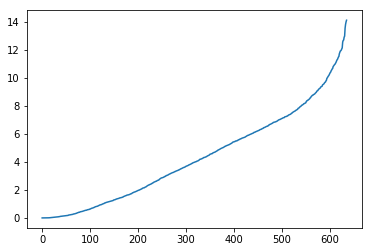

In [6]:
plt.plot(e_val)

We are usually non interested in the whole spectrum. In particular we can focus on the first (smallest) eigenvalues.

6 of them will be equal to zero, they correspond to the rototranslational null modes of the system:

Text(0.5,0,'$i$')

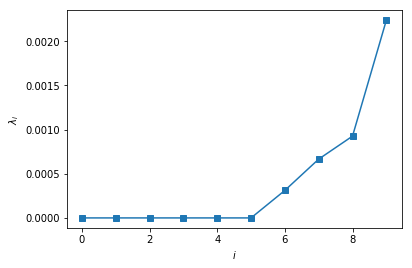

In [7]:
plt.plot(e_val[:10],marker='s')
plt.ylabel(r'$\lambda_i$')
plt.xlabel('$i$')

After these, we have the eigenvalues representing the non-null normal modes of the system.

Their amplitude is given by the inverse of the associated eigenvalue:
$\sigma_i=1 / \lambda_i$

Text(0.5,0,'$i$')

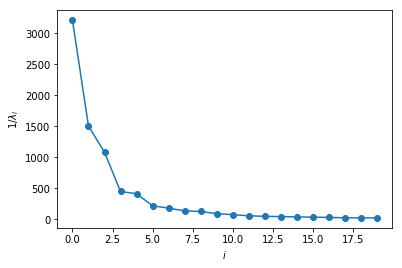

In [8]:
plt.plot(1/e_val[6:26],marker='o')
plt.ylabel(r'$1/\lambda_i$')
plt.xlabel('$i$')

## 3: Mean square fluctuations

The first information we can obtain from the ENM are the mean square fluctuations (MSF) of its beads.
This can be easily computed as:

$MSF_i=\langle \delta \mathbf{r}^2_i \rangle = \sum_\alpha 1/\lambda_\alpha \sum_\mu v^\alpha_{i,\mu} v^\alpha_{i,\mu}$

where $i=1,...,N$ is the bead index, $\mu=0,1,2$ indicates the coordinates component (x,y, or z), $\alpha=1,...,3N$ indicates the mode.

In [9]:
msf=enm_obj.get_MSF()

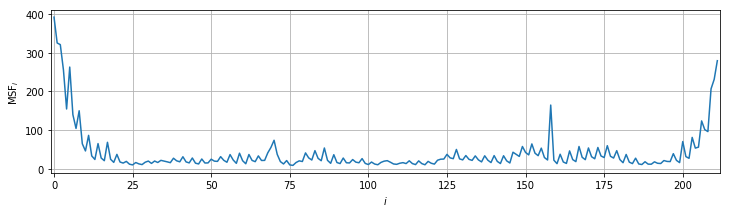

In [10]:
plt.figure(figsize=(12,3))
plt.plot(msf)
plt.ylabel('MSF$_i$')
plt.xlabel('$i$')
plt.xlim(-1,enm_obj.n_beads)
plt.grid()

The MSF usually represent a decent approximation of the B-factors obtained from crystallography

## 4: C2-C2 fluctuations

We can see that the MSFs become very large at the terminals. This is because they represent global fluctuations with respect to the equilibrium position, not local fluctuations of distances.

A way of estimating local flexibility is to compute inter-bead distances. In particular C2-C2 fluctuations have been shown to correlate well with SHAPE reactivity (Pinamonti et al. NAR 2015)

In [11]:
%time fluc_C2,reslist=enm_AA.c2_fluctuations()

CPU times: user 10.4 s, sys: 59 ms, total: 10.5 s
Wall time: 10.6 s


(-0.5, 69.5)

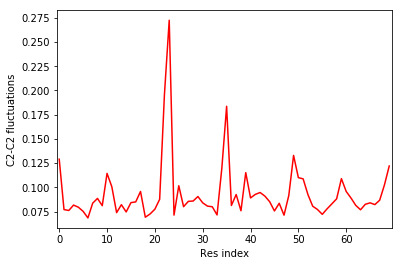

In [12]:
plt.plot(fluc_C2,c='r')
plt.ylabel('C2-C2 fluctuations')
plt.xlabel('Res index')
plt.xlim(-0.5,69.5)

## 5: Sparse diagonalization

The dynamics of the ENM is determined by the eigenvectors and eigenvalues of the interaction matrix $M_{ij}$, and the covariance matrix $C_{ij}$ can be obtained via pseudo-inversion of $M_{ij}$.

However, we are usually interested only in the eigenvectors corresponding to high amplitude modes, i.e. those with the smallest eigenvalues.

We can exploit the sparsity of $M_{ij}$ to speed up the computation of these modes.


In [13]:
%time enm_sparse=enm.Enm(fname,sparse=True,sele_atoms="AA",cutoff=0.7)

# Read  (1499, 3) coordinates
# Using sparse matrix diagonalization
CPU times: user 3.17 s, sys: 205 ms, total: 3.37 s
Wall time: 2.78 s


This is now much faster (x10) than the full-matrix diagonalization.

Text(0.5,0,'$i$')

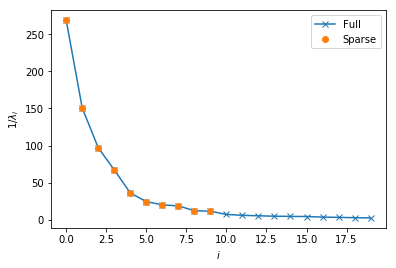

In [14]:
plt.plot(1/enm_AA.get_eval()[6:26],label='Full',marker='x')
plt.plot(1/enm_sparse.get_eval()[6:],marker='o',label='Sparse',ls='')
plt.legend()
plt.ylabel(r'$1/\lambda_i$')
plt.xlabel('$i$')

### 5b: C2-C2 fluctuations with sparse matrices:
The problem here is that all eigenvectors are required to compute these fluctuations (see formula in [2])

Thus, we cannot use the results obtained in the previous section, because computing all 3N eigenvectors would be computationally very inefficient.
Luckily, there's a nice trick to solve this.
Since we are only interested in a subset of the system (i.e. the C2 atoms), we can obtain the “effective” interaction matrix, following the formula proposed in [6], as

$M_{eff}=M_a - W M_b^{-1} W^T$

This is the matrix governing the dynamics of the C2 beads. This is convenient because $M_a$ is in general much smaller than $M_{tot}$ (1/3 for SBP-ENM, ~1/20 for AA-ENM) and is therefore much quicker to diagonalize. 

The calculation of $M_{eff}$ itself is simply performed using scipy.sparse.spsolve.

The computational time is considerably reduced when employing a AA-ENM for molecule of increasing sizes.


In [15]:
%time fluc_C2_sparse,reslist=enm_sparse.c2_fluctuations()

CPU times: user 3.4 s, sys: 366 ms, total: 3.77 s
Wall time: 3.76 s


(-0.5, 69.5)

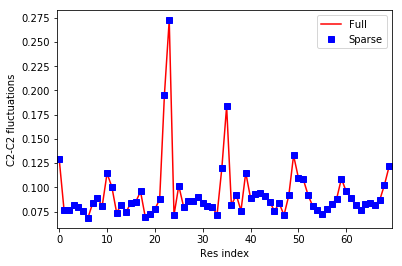

In [16]:
plt.plot(fluc_C2,c='r',label='Full')
plt.plot(fluc_C2_sparse,c='b',label='Sparse',ls='',marker='s')
plt.ylabel('C2-C2 fluctuations')
plt.xlabel('Res index')
plt.legend()
plt.xlim(-0.5,69.5)

As we can see the final result is extremely accurate, while the computational time is much reduced, already for a relatively small-sized molecule like the one used here (71 nucleotides).

## 6: Visualize the eigenmodes

What do the different eigenmodes of our ENM look like?

We can take a look at that using the method
> get_mode_traj(i)

That will return a mdtraj.trajectory object representing the fluctuations defined by the i-th eigenvector

$\mathbf{x}(t)=\mathbf{x}_0+A \mathbf{v}^i \sin(\omega t) $

In [22]:
traj_mode=enm_AA.get_mode_traj(6,amp=5.0,nframes=50)

We can take a look at this trajectory using [nglview](https://github.com/arose/nglview)

In [23]:
import nglview
view = nglview.show_mdtraj(traj_mode)
view

NGLWidget(count=50)

We can also save it as a pdb (or any other format) to visualize it later on with a different visualization software

In [26]:
traj_mode.save_pdb('./enm_traj_mode_6.pdb')

## References:
[1] Tirion, Monique M. "Large amplitude elastic motions in proteins from a single-parameter, atomic analysis." Physical review letters 77.9 (1996): 1905.

[2] Pinamonti, Giovanni, et al. "Elastic network models for RNA: a comparative assessment with molecular dynamics and SHAPE experiments." Nucleic acids research 43.15 (2015): 7260-7269.

[3] Setny, Piotr, and Martin Zacharias. "Elastic network models of nucleic acids flexibility." Journal of chemical theory and computation 9.12 (2013): 5460-5470.

[4] Zimmermann, Michael T., and Robert L. Jernigan. "Elastic network models capture the motions apparent within ensembles of RNA structures." RNA 20.6 (2014): 792-804.

[5] Fuglebakk, Edvin, Nathalie Reuter, and Konrad Hinsen. "Evaluation of protein elastic network models based on an analysis of collective motions." Journal of chemical theory and computation 9.12 (2013): 5618-5628.

[6] Zen A. Carnevale V. Lesk A.M. Micheletti C. “Correspondences between low-energy modes in enzymes: dynamics-based alignment of enzymatic functional families.” Protein Sci.  (2008) 17 918 929.
